<a href="https://colab.research.google.com/github/ItShivani/Capstone-Project/blob/master/Mumbai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd 
import numpy as np


In [16]:
!pip install -c pip-forge geopy --yes

!pip install -c pip-forge folium=0.5.0 --yes

print('Libraries installed!')


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes
Libraries installed!


In [17]:
import requests
import requests
from geopy.geocoders import Nominatim

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

print('Libraries imported!')

Libraries imported!


# Reading The Data Frame

In [18]:
dfmumbai = pd.read_csv("/content/drive/My Drive/Mumbai.csv")
dfmumbai.head()

,Area_name,Area_Location,Area_Latitude,Area_Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala Andheri,",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


# Renaming the columns

In [19]:
dfmumbai.columns = ['Area','Location','Latitude','Longitude']
dfmumbai.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala Andheri,",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


# Getting the coordinate of Mumbai using the geolocator

In [20]:
address = 'Mumbai , India'

geolocator = Nominatim(user_agent="tl-mumbai-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Mumbai are 18.9387711, 72.8353355.


# Plotting the points using Folium

In [21]:
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, long, borough, neigh in zip(dfmumbai['Latitude'], dfmumbai['Longitude'], dfmumbai['Area'], dfmumbai['Location']):
    label = "{} : {}".format(borough, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)
    
map_mumbai

# Using the Foursquare API we make a call to explore venues near these areas

In [22]:
radius = 500
LIMIT = 100
CLIENT_ID = 'LBFXES5UC5AYF5UNJYSO1LSLK5J2KASJ5NL54O4CHKBRKBKF'
CLIENT_SECRET = 'YX5CCUCAKWKPPCXGRG1MVOTP3CW3EJ2WBYAV5HNP35J3TCSX'
VERSION = '20150608'
venues = []

for lat, longi, borough, neighborhood in zip(dfmumbai['Latitude'], dfmumbai['Longitude'],  dfmumbai['Area'], dfmumbai['Location']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        longi,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [23]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Area', 'Location', 'AreaLatitude', 'AreaLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(1343, 8)


,Area,Location,AreaLatitude,AreaLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Amboli,"Andheri,Western Suburbs",19.1293,72.97,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
1,Amboli,"Andheri,Western Suburbs",19.1293,72.97,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,Amboli,"Andheri,Western Suburbs",19.1293,72.97,Subway,19.127860,72.844461,Sandwich Place
3,Amboli,"Andheri,Western Suburbs",19.1293,72.97,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,Amboli,"Andheri,Western Suburbs",19.1293,72.97,V33,19.129068,72.843670,Gym


# Seeing how many venues were returned for each Area,Location

In [24]:
venues_df.groupby(['Area', 'Location'])['VenueName'].count()

Area            Location                 
Agripada        South Mumbai                  4
Altamount Road  South Mumbai                  8
Amboli          Andheri,Western Suburbs       7
Amrut Nagar     Ghatkopar,Eastern Suburbs    37
Asalfa          Ghatkopar,Eastern Suburbs     5
                                             ..
Versova         Andheri,Western Suburbs       2
Vidyavihar      Eastern Suburbs               5
Vile Parle      Western Suburbs              37
Walkeshwar      South Mumbai                  6
Worli           South Mumbai                 11
Name: VenueName, Length: 85, dtype: int64

# Converting to One hot Representation so that K-Means can be performed

In [25]:
mumbai_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="") 

mumbai_onehot['Area'] = venues_df['Area'] 
mumbai_onehot['Location'] = venues_df['Location'] 

fixed_columns = list(mumbai_onehot.columns[-3:]) + list(mumbai_onehot.columns[:-3])
mumbai_onehot = mumbai_onehot[fixed_columns]

print(mumbai_onehot.shape)
mumbai_onehot.head()



(1343, 175)


,Yoga Studio,Area,Location,ATM,Advertising Agency,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Café,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,...,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Tea Room,Tex-Mex Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,0,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Taking the mean to see the frequency of occurence in the venue type in each area,location

In [26]:
mumbai_venues_freq = mumbai_onehot.groupby([ 'Area', 'Location']).mean().reset_index()
print(mumbai_venues_freq.shape)
mumbai_venues_freq.head()

(85, 175)


,Area,Location,Yoga Studio,ATM,Advertising Agency,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Café,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,...,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Tea Room,Tex-Mex Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,Agripada,South Mumbai,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Altamount Road,South Mumbai,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amboli,"Andheri,Western Suburbs",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Amrut Nagar,"Ghatkopar,Eastern Suburbs",0.0,0.0,0.0,0.027027,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027027,0.0,0.027027,0.0,0.027027,0.0,0.0,0.0,0.0,0.108108,0.0,0.0,0.027027,0.027027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027027,0.0,0.0,0.0,0.027027,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Asalfa,"Ghatkopar,Eastern Suburbs",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Finding the 10 most commonly occuring venue types in each area,location

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Area', 'Location']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Area'] = mumbai_venues_freq['Area']
neighborhoods_venues_sorted['Location'] = mumbai_venues_freq['Location']

for ind in np.arange(mumbai_venues_freq.shape[0]):
    row_categories = mumbai_venues_freq.iloc[ind, :].iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 2:] = row_categories_sorted.index.values[0:num_top_venues]

neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
neighborhoods_venues_sorted

,Area,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Kanjurmarg,Eastern Suburbs,ATM,Photography Studio,Bakery,Women's Store,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
48,Kemps Corner,South Mumbai,Bakery,Café,Dessert Shop,Salon / Barbershop,Coffee Shop,Sandwich Place,Pizza Place,Snack Place,Park,Brewery
11,Breach Candy,South Mumbai,Bakery,Café,Sandwich Place,Coffee Shop,Dessert Shop,Pizza Place,Snack Place,Bookstore,Italian Restaurant,Japanese Restaurant
57,Marine Drive,South Mumbai,Bakery,Train Station,Bridal Shop,Chinese Restaurant,Indian Restaurant,Scenic Lookout,Italian Restaurant,Café,Women's Store,Falafel Restaurant
34,Dongri,South Mumbai,Beach,Bus Station,Playground,Indian Restaurant,Resort,Women's Store,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
67,Navy Nagar,"Colaba,South Mumbai",Stables,Women's Store,Field,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run,Diner
64,Naigaon,"Vasai,Western Suburbs",Train Station,Platform,Women's Store,Dessert Shop,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run,Diner
71,Parel,South Mumbai,Whisky Bar,Plaza,Indian Restaurant,Women's Store,Dessert Shop,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run
22,Cotton Green,South Mumbai,Whisky Bar,Train Station,Bakery,Plaza,Women's Store,Dhaba,Falafel Restaurant,Event Space,Electronics Store,Donut Shop


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline 
kclusters = 3

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(mumbai_venues_freq_clustering)
    distortions.append(kmeanModel.inertia_)



plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

NameError: ignored

# K-Means Clustering

In [33]:
kclusters = 5

mumbai_venues_freq_clustering = mumbai_venues_freq.drop(['Area', 'Location'], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_venues_freq_clustering)
mumbai_clustered_df = dfmumbai[:85]
mumbai_clustered_df['Cluster'] = kmeans.labels_

mumbai_clustered_df = mumbai_clustered_df.join(neighborhoods_venues_sorted.drop(['Location'], 1).set_index('Area'), on='Area')
mumbai_clustered_df.sort_values(['Cluster'] + freqColumns, inplace=True)
mumbai_clustered_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Area,Location,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,Marine Lines,South Mumbai,18.944700,72.824400,0,Café,Bakery,Indian Restaurant,Indie Movie Theater,Chinese Restaurant,Mexican Restaurant,Bridal Shop,Portuguese Restaurant,Italian Restaurant,Scenic Lookout
17,Dahisa,Western Suburbs,19.250069,72.859347,0,Café,Train Station,Restaurant,Pizza Place,Bar,Dog Run,Indian Restaurant,Dhaba,Event Space,Electronics Store
55,Breach Candy,South Mumbai,18.967000,72.805000,1,Bakery,Café,Sandwich Place,Coffee Shop,Dessert Shop,Pizza Place,Snack Place,Bookstore,Italian Restaurant,Japanese Restaurant
71,Marine Drive,South Mumbai,18.944000,72.823000,1,Bakery,Train Station,Bridal Shop,Chinese Restaurant,Indian Restaurant,Scenic Lookout,Italian Restaurant,Café,Women's Store,Falafel Restaurant
32,Nalasopara,"Vasai,Western Suburbs",19.415400,72.861300,1,Bus Station,Seafood Restaurant,Bar,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,Virar,Western Suburbs,19.470000,72.800000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,Vikhroli,Eastern Suburbs,19.110000,72.940000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,Mahul,"Trombay,Harbour Suburbs",19.000000,72.883333,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Mahalaxmi,South Mumbai,18.983333,72.800000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plotting the clusters on the Map using Folium

In [34]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, poi, cluster in zip(mumbai_clustered_df['Latitude'], mumbai_clustered_df['Longitude'], mumbai_clustered_df['Area'], mumbai_clustered_df['Location'], mumbai_clustered_df['Cluster']):
    label = folium.Popup('{}: {} - Cluster {}'.format(bor, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Now for Analyzing Rents in different parts of the City

In [99]:
newdf = pd.read_csv("/content/drive/My Drive/Scrape.csv",dtype={"Rent": float})
newdf.columns = ['Locality','Rent']
newdf.head()


,Locality,Rent
0,Thane West,27333.33
1,Mira Road East,30000.00
2,Kharghar,32000.00
3,Chembur,39000.00
4,Kandivali East,33694.62


# Sort in ascending order

In [120]:
newdf.sort_values(by=['Rent'], inplace=True)

In [121]:
newdf.set_index('Locality')

,Rent
Locality,
Dombivali East,5000.00
Ghansoli,5500.00
Badlapur West,6933.33
Virar,8000.00
Ambernath East,8298.86
Badlapur East,8500.00
Naigaon East,8527.78
Ambernath West,9500.00
Nala Sopara,9923.58


In [122]:
newdf.dtypes

Locality     object
Rent        float64
dtype: object

# Plotting the bar graph

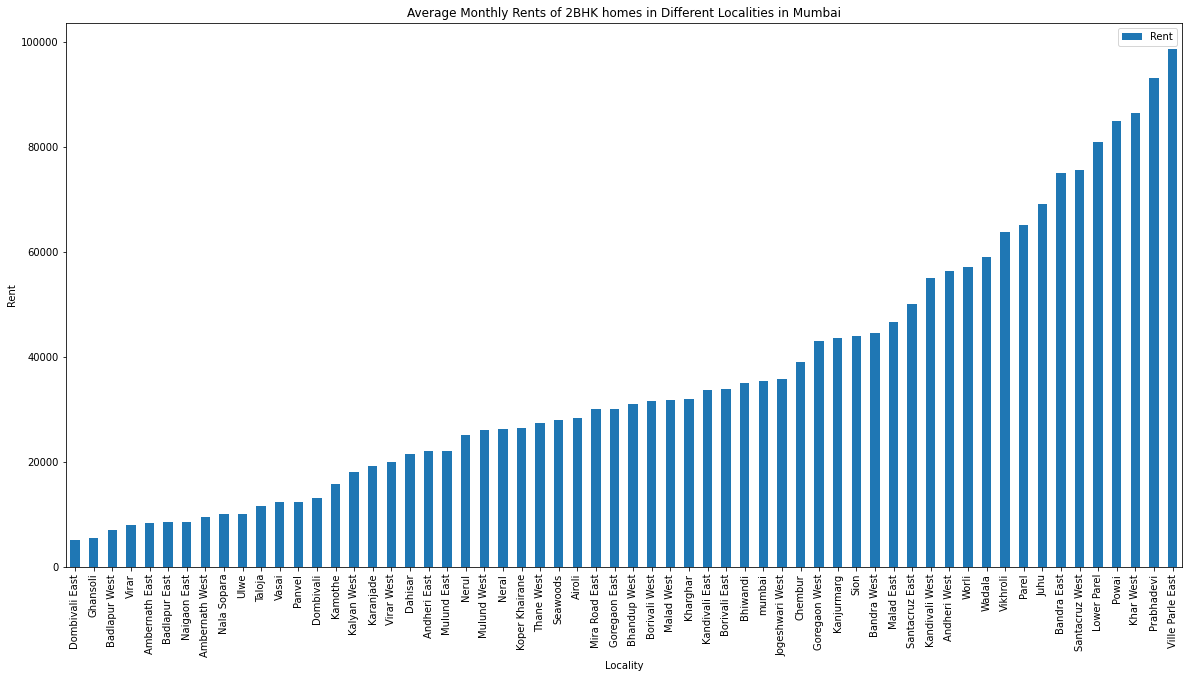

In [123]:

newdf.plot.bar(x="Locality", y="Rent", rot=90 ,figsize = (20,10))

plt.xlabel('Locality')
plt.ylabel('Rent')
plt.title("Average Monthly Rents of 2BHK homes in Different Localities in Mumbai")
plt.show()
